# Volatility Breakout Trading System

## Load Data

In [677]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [678]:
filepath = "../data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

## Trading System

In [679]:
# Define date range
start_date = '2023-11-01'
end_date = '2024-06-30'

# Filter the dataset
df = df.loc[start_date:end_date].copy()

In [680]:
# Parameters
initial_capital = 10000         # Initial capital in PLN
short_window = 2                # number of sessions for fast ATR calculation
long_window = 14                # number of sessions for slow ATR calculation
signal_adj = 0.4                # adjustment of fast ATR signal (default=0.4)
risk_percent = 0.04             # risk per trade
point_value = 20                # 20 PLN per point
commission_per_contract = 8.5   # PLN per round trip per contract

### Indicator Calculation

In [681]:
# calculate ATR
df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_short'] = df['TR'].rolling(window=short_window).mean()
df['ATR_long'] = df['TR'].rolling(window=long_window).mean()

### Signal Logic

In [682]:
# generate signals
df['Signal'] = (df['ATR_short'] * signal_adj).bfill().astype(int)
df['Buy_Level'] = (df['Open'] + df['Signal'].shift(1)).astype(float)
df['Sell_Level'] = (df['Open'] - df['Signal'].shift(1)).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Buy_Level']) & df['Buy_Level'].notna()
df['Short_Entry'] = (df['Low'] < df['Sell_Level']) & df['Sell_Level'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
position = []
entry_price = []
current_pos = 0  # 1 = long, -1 = short, 0 = flat
last_entry = np.nan

for i in range(len(df)):
    long_signal = df['Long_Entry'].iloc[i]
    short_signal = df['Short_Entry'].iloc[i]

    if current_pos == 0:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]
        elif short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == 1:
        if short_signal:
            current_pos = -1
            last_entry = df['Sell_Level'].iloc[i]

    elif current_pos == -1:
        if long_signal:
            current_pos = 1
            last_entry = df['Buy_Level'].iloc[i]

    position.append(current_pos)
    entry_price.append(last_entry)

df['Position'] = position
df['Entry_Price'] = entry_price

### Result Calculation

In [683]:
# --- Initialization ---
df['Daily_Pts'] = np.nan
df['Daily_Pnl'] = np.nan
df['Position_Size'] = np.nan
df['Capital'] = np.nan

capital = initial_capital
capital_list = [capital]
commission_list = []
size_list = [np.nan]

risk_per_contract_list = []
risk_amount_list = []

# Loop through rows
for i in range(1, len(df)):
    prev_pos = df['Position'].iloc[i - 1]
    curr_pos = df['Position'].iloc[i]
    curr_close = df['Close'].iloc[i]
    prev_close = df['Close'].iloc[i - 1]
    entry_price = df['Entry_Price'].iloc[i]


    # Calculate risk per contract based on ATR
    atr = df['ATR_long'].iloc[i]
    risk_per_contract = atr * point_value if pd.notna(atr) and atr > 0 else np.nan

    if pd.notna(risk_per_contract) and risk_per_contract > 0:
        risk_amount = capital * risk_percent
        size = int(risk_amount / risk_per_contract)
        if size < 1:
            size = 1
        elif size > 100:
            size = 100
    else:
        size = 1  # No trade if ATR is missing or zero

     # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and prev_pos != 0 and curr_pos != 0:
        daily_pts = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)
        commission = (commission_per_contract * size) * 2
        
    # Case 2: New position opened from flat
    elif prev_pos == 0 or curr_pos == 0:
        daily_pts = (curr_close - entry_price) * curr_pos
        commission = (commission_per_contract * size)

    # Case 3: Holding position
    elif curr_pos == prev_pos and curr_pos != 0 and prev_pos != 0:
        daily_pts = (curr_close - prev_close) * curr_pos
        commission = 0

    else:
        daily_pts = 0  # flat
        commission = 0

    daily_pnl = daily_pts * size * point_value
    net_daily_pnl = daily_pnl - commission
    capital += net_daily_pnl

    # Save results
    df.at[df.index[i], 'Daily_Pts'] = daily_pts
    df.at[df.index[i], 'Position_Size'] = size
    df.at[df.index[i], 'Commission'] = commission
    df.at[df.index[i], 'Capital'] = capital

    # df.at[df.index[i], 'Risk_per_contract'] = risk_per_contract
    # df.at[df.index[i], 'Risk_amount'] = risk_amount

    capital_list.append(capital)
    size_list.append(size)    

# Fill missing initial values
df.loc[df.index[0], 'Capital'] = initial_capital
df.loc[df.index[0], 'Position_Size'] = 0

# Cumulative metrics
df['Daily_PnL'] = df['Daily_Pts'] * df['Position_Size'] * point_value
df['Cumulative_Pts'] = df['Daily_Pts'].cumsum()
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum()


In [684]:
# --- Calculate Drawdown ---
df['Capital_Hwm'] = df['Capital'].cummax()
df['Drawdown'] = df['Capital'] - df['Capital_Hwm']
df['Drawdown_Pct'] = df['Drawdown'] / df['Capital_Hwm'].replace(0, np.nan)
max_drawdown = df['Drawdown'].min()
max_drawdown_pct = df['Drawdown_Pct'].min()
print(f"Max Drawdown: {max_drawdown}, Max Drawdown %: {max_drawdown_pct}")

Max Drawdown: -3922.0, Max Drawdown %: -0.2453013103167902


In [685]:
df[['Open', 'High', 'Low', 'Close', 'ATR_short', 'ATR_long', 'Signal', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Capital', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown']].head(20)

,Open,High,Low,Close,ATR_short,ATR_long,Signal,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Capital,Cumulative_PnL,Capital,Capital_Hwm,Drawdown
Date,,,,,,,,,,,,,,,,,,,,
2023-11-02,2195,2203,2153,2172,NaN,NaN,17,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,10000.0,NaN,10000.0,10000.0,0.0
2023-11-03,2174,2201,2165,2187,43.0,NaN,17,2191.0,2157.0,2191.0,1,-4.0,-80.0,1.0,8.5,9911.5,-80.0,9911.5,10000.0,-88.5
2023-11-06,2194,2216,2184,2199,34.0,NaN,13,2211.0,2177.0,2191.0,1,12.0,240.0,1.0,0.0,10151.5,160.0,10151.5,10151.5,0.0
2023-11-07,2188,2200,2163,2184,34.5,NaN,13,2201.0,2175.0,2175.0,-1,-33.0,-660.0,1.0,17.0,9474.5,-500.0,9474.5,10151.5,-677.0
2023-11-08,2177,2183,2147,2152,37.0,NaN,14,2190.0,2164.0,2175.0,-1,32.0,640.0,1.0,0.0,10114.5,140.0,10114.5,10151.5,-37.0
2023-11-09,2157,2187,2140,2182,42.0,NaN,16,2171.0,2143.0,2171.0,1,-8.0,-160.0,1.0,17.0,9937.5,-20.0,9937.5,10151.5,-214.0
2023-11-10,2176,2180,2145,2150,42.0,NaN,16,2192.0,2160.0,2160.0,-1,-12.0,-240.0,1.0,17.0,9680.5,-260.0,9680.5,10151.5,-471.0
2023-11-13,2159,2177,2132,2132,41.0,NaN,16,2175.0,2143.0,2175.0,1,-68.0,-1360.0,1.0,17.0,8303.5,-1620.0,8303.5,10151.5,-1848.0
2023-11-14,2141,2258,2140,2258,85.5,NaN,34,2157.0,2125.0,2175.0,1,126.0,2520.0,1.0,0.0,10823.5,900.0,10823.5,10823.5,0.0


In [686]:
df[['Open', 'High', 'Low', 'Close', 'ATR_short', 'ATR_long', 'Signal', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown', 'Drawdown_Pct']].tail(20)

,Open,High,Low,Close,ATR_short,ATR_long,Signal,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Cumulative_PnL,Capital,Capital_Hwm,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,
2024-06-03,2512,2531,2504,2505,45.0,37.500000,18,2532.0,2492.0,2485.0,1,14.0,280.0,1.0,0.0,5520.0,14389.5,15988.5,-1599.0,-0.100009
2024-06-04,2502,2503,2440,2440,52.5,39.142857,21,2520.0,2484.0,2484.0,-1,23.0,460.0,1.0,17.0,5980.0,14832.5,15988.5,-1156.0,-0.072302
2024-06-05,2455,2457,2434,2450,44.0,38.928571,17,2476.0,2434.0,2484.0,-1,-10.0,-200.0,1.0,0.0,5780.0,14632.5,15988.5,-1356.0,-0.084811
2024-06-06,2463,2475,2442,2468,28.0,39.214286,11,2480.0,2446.0,2484.0,-1,-18.0,-360.0,1.0,0.0,5420.0,14272.5,15988.5,-1716.0,-0.107327
2024-06-07,2475,2475,2423,2430,42.5,40.000000,17,2486.0,2464.0,2484.0,-1,38.0,760.0,1.0,0.0,6180.0,15032.5,15988.5,-956.0,-0.059793
2024-06-10,2424,2435,2403,2431,42.0,40.000000,16,2441.0,2407.0,2484.0,-1,-1.0,-20.0,1.0,0.0,6160.0,15012.5,15988.5,-976.0,-0.061044
2024-06-11,2434,2444,2404,2410,36.0,40.285714,14,2450.0,2418.0,2484.0,-1,21.0,420.0,1.0,0.0,6580.0,15432.5,15988.5,-556.0,-0.034775
2024-06-12,2419,2460,2415,2446,45.0,41.571429,18,2433.0,2405.0,2433.0,1,-10.0,-200.0,1.0,17.0,6380.0,15215.5,15988.5,-773.0,-0.048347
2024-06-13,2443,2444,2399,2403,48.5,42.285714,19,2461.0,2425.0,2425.0,-1,1.0,20.0,1.0,17.0,6400.0,15218.5,15988.5,-770.0,-0.048160


### Evaluation

Text(0, 0.5, 'Points')

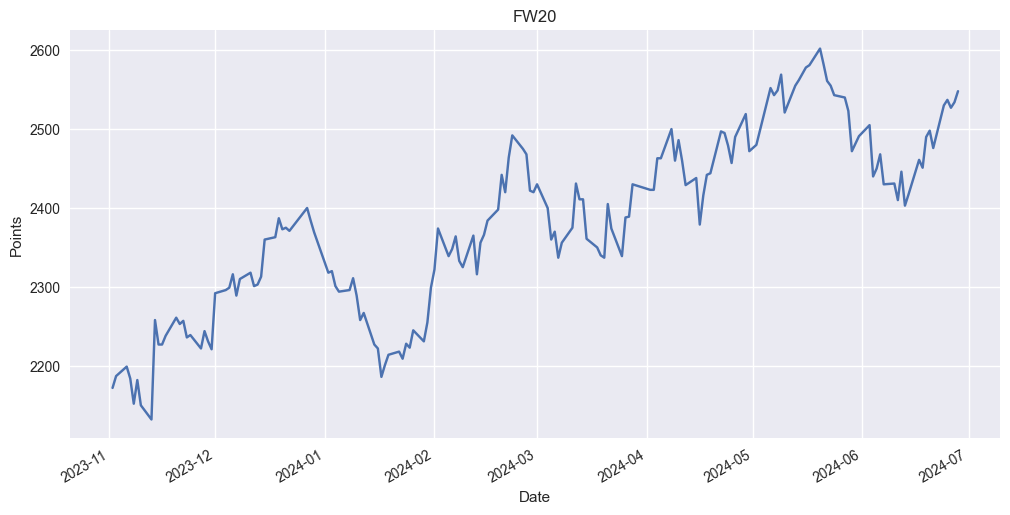

In [687]:
df['Close'].plot(title='FW20', figsize=(12, 6))
plt.ylabel('Points')

Text(0, 0.5, 'Average True Range (in Points)')

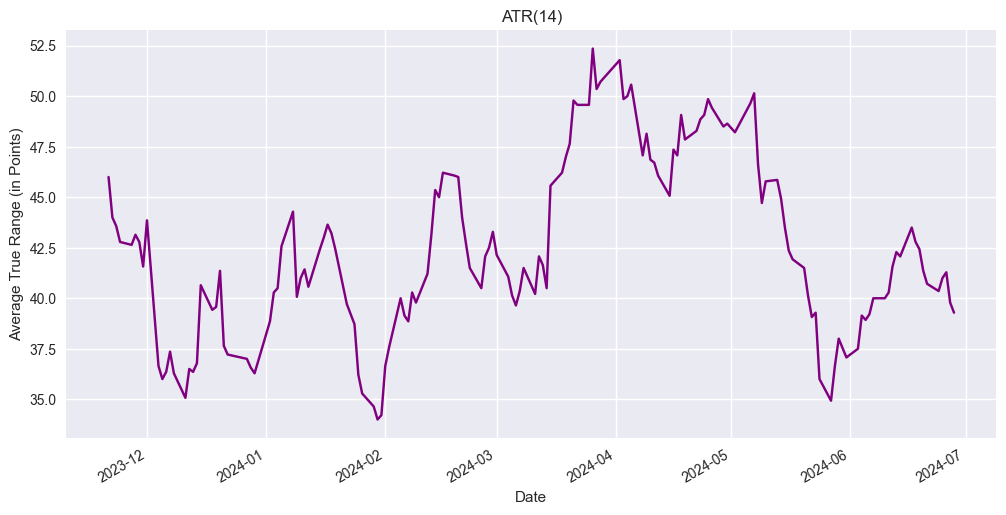

In [688]:
df['ATR_long'].plot(title=f"ATR({long_window})", figsize=(12, 6), color='purple')
plt.ylabel('Average True Range (in Points)')

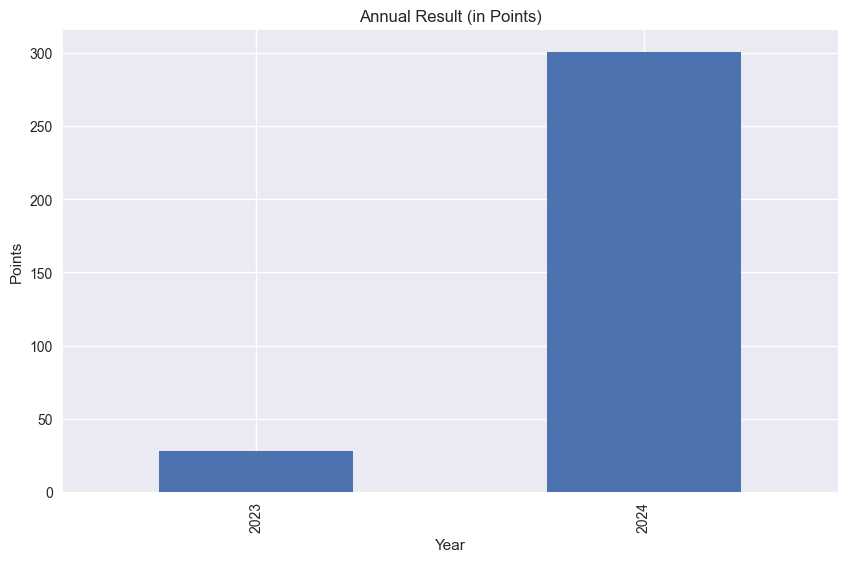

In [689]:
df['Daily_Pts'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Result (in Points)', figsize=(10, 6))
plt.ylabel('Points')
plt.xlabel('Year')
plt.show()

In [690]:
df['Daily_Pts'].groupby(df.index.year).sum()

Date
2023     28.0
2024    301.0
Name: Daily_Pts, dtype: float64

Text(0, 0.5, 'Cumulative Points')

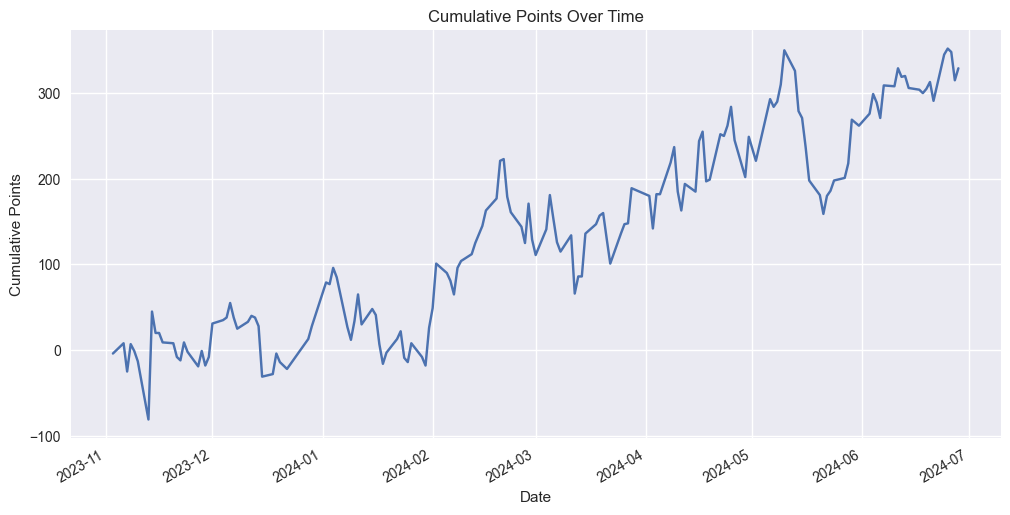

In [691]:
df['Cumulative_Pts'].plot(title='Cumulative Points Over Time', figsize=(12, 6))
plt.ylabel('Cumulative Points')

Text(0, 0.5, 'Capital (PLN)')

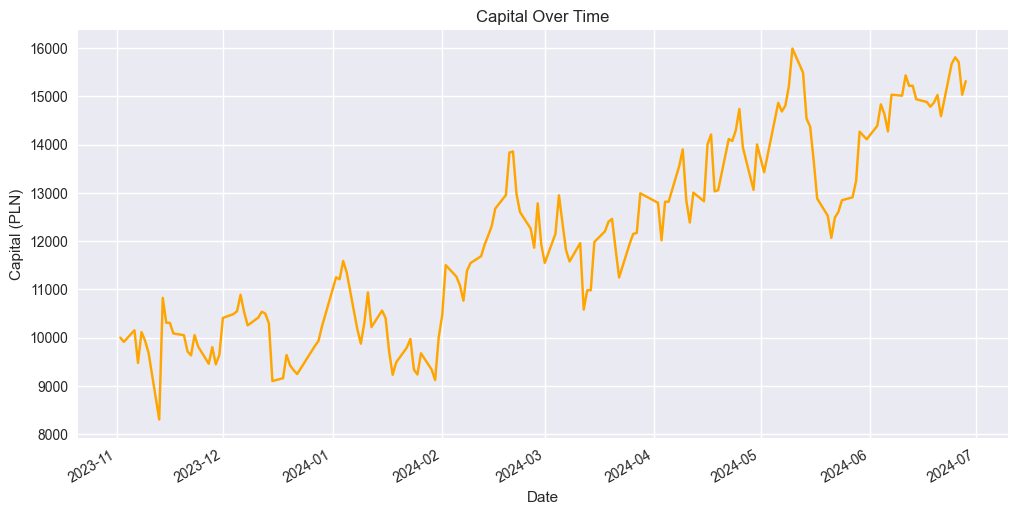

In [692]:
df['Capital'].plot(title='Capital Over Time', figsize=(12, 6), color='orange')
plt.ylabel('Capital (PLN)')

Text(0, 0.5, 'Drawdown (PLN)')

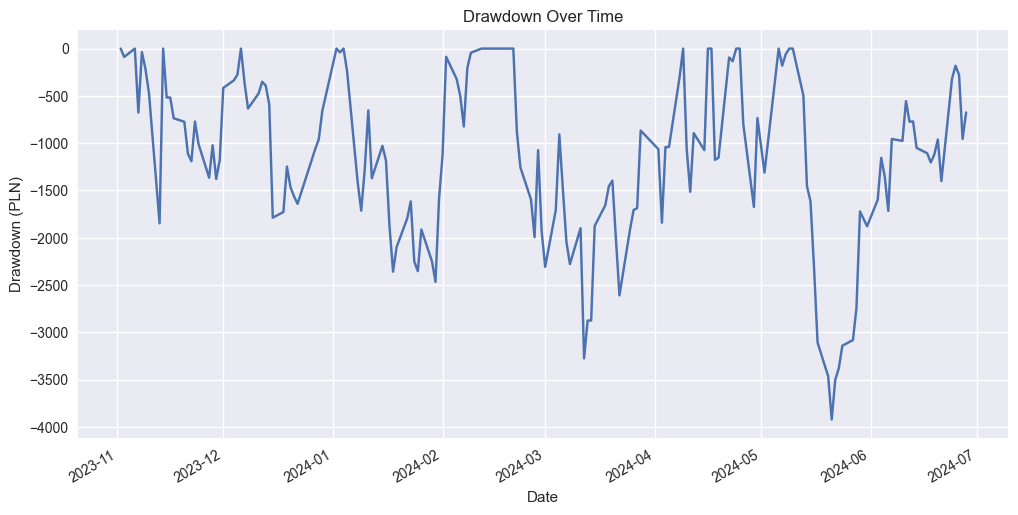

In [693]:
df['Drawdown'].plot(title='Drawdown Over Time', figsize=(12, 6))
plt.ylabel('Drawdown (PLN)')

Text(0, 0.5, 'Drawdown Percentage (%)')

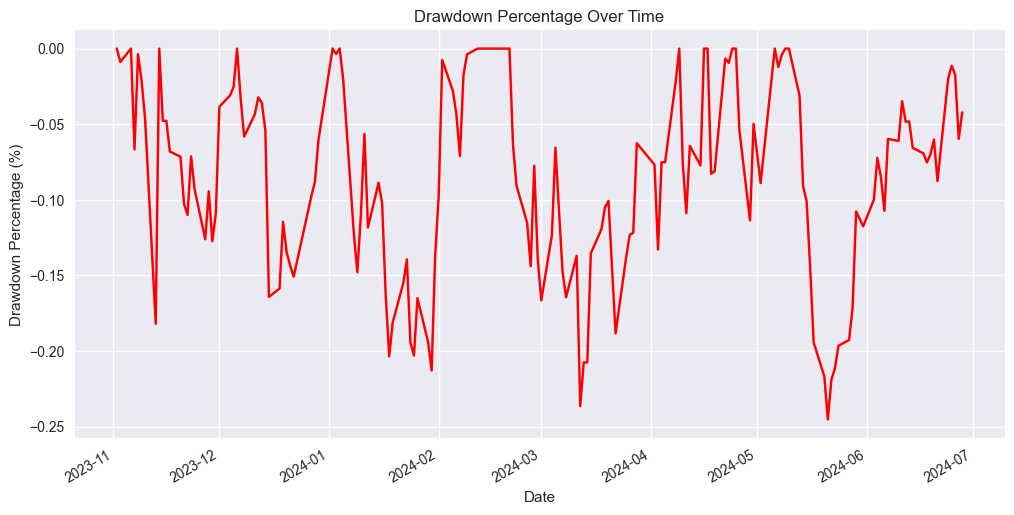

In [694]:
df['Drawdown_Pct'].plot(title='Drawdown Percentage Over Time', figsize=(12, 6), color='red')
plt.ylabel('Drawdown Percentage (%)')

Text(0, 0.5, 'Position Size')

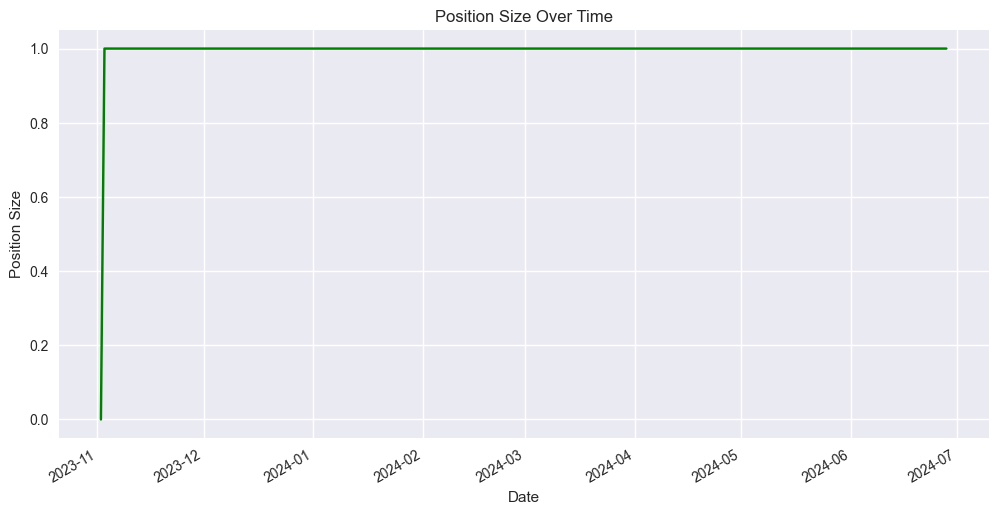

In [695]:
df['Position_Size'].plot(title='Position Size Over Time', figsize=(12, 6), color='green')
plt.ylabel('Position Size')

### Performance Metrics Calculation

In [696]:
trades = []
current_pos = 0
entry_price = None
entry_index = None
pnl = 0

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    # Entry
    if current_pos == 0 and row['Position'] != 0:
        current_pos = row['Position']
        entry_price = row['Entry_Price']
        entry_index = df.index[i]
        pnl = 0

    # Still in position
    elif current_pos != 0 and row['Position'] == current_pos:
        pnl += row['Daily_Pts']

    # Exit or flip
    elif current_pos != 0 and row['Position'] != current_pos:
        # pnl += row['Daily_Pts']
        pnl = (row['Entry_Price'] - prev_row['Entry_Price']) * current_pos
        exit_index = df.index[i]
        trades.append({
            'Entry_Date': entry_index,
            'Exit_Date': exit_index,
            'Position': current_pos,
            'PnL': pnl
        })

        # Start new trade if flipped
        if row['Position'] != 0:
            current_pos = row['Position']
            entry_price = row['Entry_Price']
            entry_index = df.index[i]
            pnl = 0
        else:
            current_pos = 0
            entry_price = None
            entry_index = None
            pnl = 0

In [697]:
trades_df = pd.DataFrame(trades)

In [698]:
total_trades = len(trades_df)

# --- Basic Trade Statistics ---

# Subsets
winning_trades = trades_df[trades_df['PnL'] >= 0]
losing_trades = trades_df[trades_df['PnL'] < 0]

# Counts
no_profitable_trades = len(winning_trades)
no_losing_trades = len(losing_trades)
winrate = no_profitable_trades / total_trades if total_trades > 0 else 0

# Calculate average profit per winning trade
avg_profit = winning_trades['PnL'].mean()

# Calculate average loss per losing trade
avg_loss = losing_trades['PnL'].mean()  # This will be negative

# Calculate payout ratio
if avg_loss != 0:
    payout_ratio = avg_profit / abs(avg_loss)
else:
    payout_ratio = np.nan  # Avoid division by zero

edge = (winrate * payout_ratio) - (1 - winrate)

# --- Risk-Adjusted Performance ---

daily_returns = df['Daily_PnL'] / df['Capital'].shift(1)
negative_returns = daily_returns[daily_returns < 0]

# Sharpe Ratio
sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

# Sortino Ratio
sortino = daily_returns.mean() / negative_returns.std() * np.sqrt(252)

# Drawdowns
max_dd = df['Drawdown'].min()
max_dd_pct = df['Drawdown_Pct'].min()
romad = df['Cumulative_PnL'].iloc[-1] / abs(max_dd) if max_dd != 0 else np.nan

gross_profit = winning_trades['PnL'].sum()
gross_loss = losing_trades['PnL'].sum()
expectancy = (winrate * avg_profit) + ((1 - winrate) * avg_loss)

holding_days = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days
avg_holding_period = holding_days.mean()




In [699]:
num_years = (df.index[-1] - df.index[0]).days / 365.25

final_capital = df['Capital'].iloc[-1]

if num_years > 0 and initial_capital > 0:
    cagr = (final_capital / initial_capital) ** (1 / num_years) - 1
else:
    cagr = np.nan



### Performance Metrics

In [700]:
# Print results
print("Start date: ", start_date)
print("End date:", end_date)
print("-------------------")
print("Total Trades:", total_trades)
print("Profitable Trades:", no_profitable_trades)
print("Losing Trades:", no_losing_trades)
print("Win Rate:", round(no_profitable_trades / total_trades * 100, 2), "%")
print(f"Average Profit per Trade: {avg_profit:.2f}")
print(f"Average Loss per Trade: {avg_loss:.2f}")
print(f"Payout Ratio: {payout_ratio:.2f}")
print(f"Edge: {edge:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max DD: {max_dd:.2f}")
print(f"Max DD %: {max_dd_pct*100:.2f}%")
print(f"RoMaD: {romad:.2f}")
print(f"Expectancy: {expectancy:.2f}")
print(f"Avg Holding Period: {avg_holding_period:.2f}")
print("-------------------")
print(f"Initial capital: {initial_capital:,.2f}")
print(f"Final capital: {final_capital:,.2f}")
print(f"CAGR: {cagr*100:.2f}%")

Start date:  2023-11-01
End date: 2024-06-30
-------------------
Total Trades: 74
Profitable Trades: 32
Losing Trades: 42
Win Rate: 43.24 %
Average Profit per Trade: 36.91
Average Loss per Trade: -20.31
Payout Ratio: 1.82
Edge: 0.22
Sharpe Ratio: 1.42
Sortino Ratio: 2.57
Max DD: -3922.00
Max DD %: -24.53%
RoMaD: 1.68
Expectancy: 4.43
Avg Holding Period: 3.20
-------------------
Initial capital: 10,000.00
Final capital: 15,313.50
CAGR: 91.80%


In [701]:
print('Biggest winning trade:')
trades_df.loc[trades_df['PnL'].idxmax()]

Biggest winning trade:


Entry_Date    2024-01-30 00:00:00
Exit_Date     2024-02-05 00:00:00
Position                        1
PnL                         103.0
Name: 30, dtype: object

In [702]:
print('Biggest losing trade:')
trades_df.loc[trades_df['PnL'].idxmin()]

Biggest losing trade:


Entry_Date    2024-05-14 00:00:00
Exit_Date     2024-05-16 00:00:00
Position                       -1
PnL                         -56.0
Name: 61, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

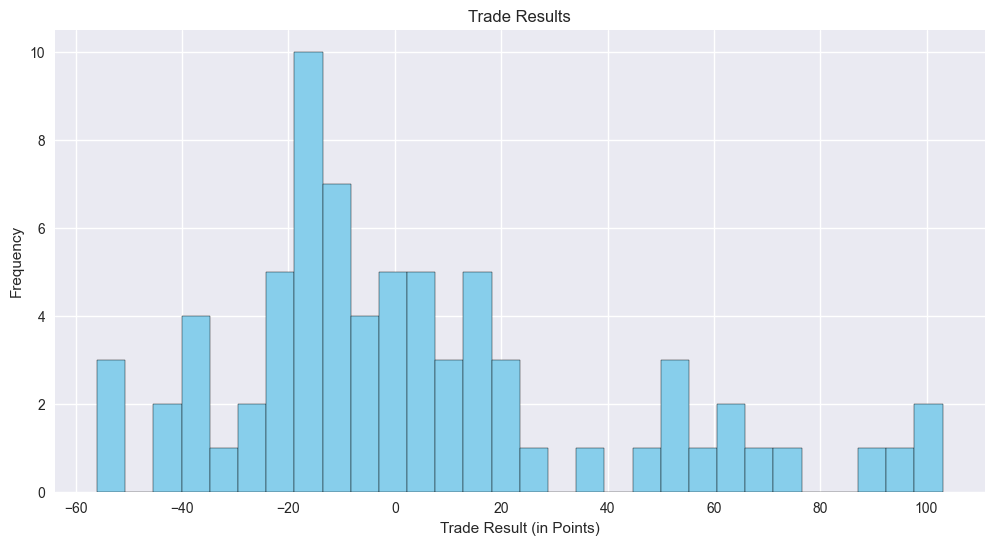

In [703]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.hist(trades_df['PnL'], bins=30, color='skyblue', edgecolor='black')
plt.title('Trade Results')
plt.xlabel('Trade Result (in Points)')
plt.ylabel('Frequency')
plt.show

In [704]:
print('Current trade:')
df[['Entry_Price', 'Close', 'Position', 'Signal']].iloc[-1]

Current trade:


Entry_Price    2547.0
Close          2548.0
Position          1.0
Signal           11.0
Name: 2024-06-28 00:00:00, dtype: float64